# **Music Recommendation System**

-----------------
### **Context**
With the advent of technology, societies have become more efficient with their lives. But at the same time, individual human lives have become much more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has made it easier for humans with a shortage of time to find and consume good content. Therefore, one of the key challenges for the companies is to be able to figure out what kind of content their customers are most likely to consume. Almost every internet-based company's revenue relies on the time consumers spend on their platforms. These companies need to be able to figure out what kind of content is needed to increase the time spent by customers on their platform and make their experience better.
Spotify is one such audio content provider that has got a huge market base across the world. It has grown significantly because of its ability to recommend the ‘best’ next song to each and every customer based on the huge preference database they have gathered over time like millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on the users’ likes/dislikes

------------------
### **Objective**
To recommend songs to a user based on their likelihood of liking those songs.

------------------------
### **The key questions**
- What are all songs they have listened to?
- What are the most favored songs and artists?

-----------------------------
### **Problem Formulation**

Build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

-------------------------
### **Data Dictionary**

The core data is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

#### **song_data**
**song_id** - A unique id given to every song

**title** - Title of the song

**Release** - Name of the released album

**Artist_name** - Name of the artist 

**year** - Year of release

#### **count_data**
**user_id** - A unique id given to the user

**song_id** - A unique id given to the song

**play_count** - Number of times the song was played

---------------------
### **Data Source**
- http://millionsongdataset.com/



In [1]:
# Mounting the drive
# from google.colab import drive
# drive.mount('/content/drive')

I need to install surprise library but solved the issue installing through conda: 
conda install -c conda-forge scikit-surprise

In [2]:
# !pip install surprise

## **Import Libraries**

In [3]:
import pandas as pd 
import numpy as np 
 
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

from collections import defaultdict

from surprise import accuracy, CoClustering
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD

from sklearn.metrics import mean_squared_error

## **Import Dataset**

In [4]:
count_df = pd.read_csv('count_data.csv')
song_df = pd.read_csv('song_data.csv')

In [5]:
count_df.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB


In [7]:
count_df.duplicated().sum()

0

In [8]:
count_df.isnull().sum()

Unnamed: 0    0
user_id       0
song_id       0
play_count    0
dtype: int64

In [9]:
count_df['song_id'].nunique()

10000

- The count_df doesn't have any missing or duplicate values. 
- The count_fg has 2M datapoint, linking songs with users and how many times the songs played by users. 
- The dataset has 4 columns two numerical and 2 object. The unamed column is the indexing and can be drop from the data.
- Only 10k unique song exist in this dataset. 

In [10]:
song_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [11]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999983 non-null   object
 2   release      999993 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [12]:
song_df.duplicated().sum()

498

In [13]:
song_df.isnull().sum()

song_id         0
title          17
release         7
artist_name     0
year            0
dtype: int64

In [14]:
song_df[song_df.isnull().any(axis=1)]

,song_id,title,release,artist_name,year
64262,SOVICLT12A58A7C4D0,NaN,Of Flies And Men,Milton,0
64788,SOESMJQ12A6D4FE563,Aztec Two-Step,NaN,Meshuggah,1994
110154,SOZGJGY12A8159E898,NaN,Frailty,The Duskfall,2002
114672,SOAGRAA12AB018D567,NaN,Puce de luxe,Sébastien Roch,0
138011,SOOBGAQ12A6D4F6762,Solitude,NaN,Metro,0
197822,SOGFJER12A6D4F675F,All The Beautiful People,NaN,Metro,0
223019,SOAFJBH12A6D4F6765,Down The Aisles,NaN,Metro,0
229353,SOOAFJX12AB018A028,NaN,Puce de luxe,Sébastien Roch,0
264639,SOLDTFD12AB018AFE6,NaN,Puce de luxe,Sébastien Roch,0
304580,SOFIWTV12A6D4F92C3,Sickening,NaN,Meshuggah,1994


- The song_df contains information about 1M songs. 
- 498 duplicate lines are found in this dataset. 
- 17 titles and 7 releases are missing in this dataset. 
- The dataset has 5 columns which 4 of them are object type and one of it is integar. 

#### **Merge Datasets**

In [15]:
merge_df = pd.merge(count_df, song_df.drop_duplicates(['song_id']), on='song_id', how='left')
merge_df.drop(['Unnamed: 0'], axis=1, inplace=True)
merge_df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [16]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   song_id      object
 2   play_count   int64 
 3   title        object
 4   release      object
 5   artist_name  object
 6   year         int64 
dtypes: int64(2), object(5)
memory usage: 106.8+ MB


In [17]:
merge_df.duplicated().sum()

0

In [18]:
merge_df.isnull().sum()

user_id        0
song_id        0
play_count     0
title          0
release        0
artist_name    0
year           0
dtype: int64

#### **Reduce size of Dataset**

- merge_df has 2M data with 7 columns, 2 numerical and 5 object types. 
- Note that in this new merge dataframe we don't have any missing values. The main reason behind it is that form 1M songs in the song_df only 10K of it exist in the count_df so as we merge the data together will lose information about 990 K songs which are not exists in the count_df and probably the missing values were from the songs that doesn't exist in the count_df 
- The user_id and song_id are encrypted we can perform lablencoder on them. 


In [19]:
labelenconder = LabelEncoder()
merge_df['user_id'] = labelenconder.fit_transform(merge_df['user_id'])
merge_df['song_id'] = labelenconder.fit_transform(merge_df['song_id'])
merge_df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


- In order to solve this problem with the resourses that I have, I am going to try to decrease the size of my dataset by only considering the users listen to more than 90 songs and songs that played by at least 120 users.  

In [39]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int32 
 1   song_id      int32 
 2   play_count   int64 
 3   title        object
 4   release      object
 5   artist_name  object
 6   year         int64 
dtypes: int32(2), int64(2), object(3)
memory usage: 91.6+ MB


In [20]:
df1 = merge_df[merge_df['user_id'].map(merge_df['user_id'].value_counts()) >= 90]
df1

,user_id,song_id,play_count,title,release,artist_name,year
196,6958,12,1,Aunt Eggma Blowtorch,Everything Is,Neutral Milk Hotel,1995
197,6958,40,1,Full Circle,Breakout,Miley Cyrus,2008
198,6958,151,2,Poor Jackie,Rabbit Habits,Man Man,2008
199,6958,326,1,Hot N Cold (Manhattan Clique Remix Radio Edit),Hot N Cold,Katy Perry,2008
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
...,...,...,...,...,...,...,...
1999765,47786,9847,1,He Can Only Hold Her,Back To Black,Amy Winehouse,2006
1999766,47786,9858,5,Drunk Kid Catholic,Noise Floor [Rarities 98 - 05],Bright Eyes,2000
1999767,47786,9890,2,Cool Dry Place (2007 Remastered LP Version),Traveling Wilburys Vol. 3,Traveling Wilburys,0
1999768,47786,9954,3,Let's Live For Today,150 Rock 'N' Roll Classics,The Grass Roots,1987


In [21]:
df2 = df1[df1['song_id'].map(df1['song_id'].value_counts()) >= 120]
df2

,user_id,song_id,play_count,title,release,artist_name,year
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
...,...,...,...,...,...,...,...
1999735,47786,9160,7,Sala De Recepção,O Mundo E Um Moinho,Cartola,1976
1999736,47786,9186,1,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,1997
1999745,47786,9351,2,The Police And The Private,Live It Out,Metric,2005
1999755,47786,9543,1,Just Friends,Back To Black,Amy Winehouse,2006


In [22]:
df2.groupby(['play_count']).count()

,user_id,song_id,title,release,artist_name,year
play_count,,,,,,
1,72473,72473,72473,72473,72473,72473
2,23890,23890,23890,23890,23890,23890
3,10774,10774,10774,10774,10774,10774
4,5874,5874,5874,5874,5874,5874
5,4865,4865,4865,4865,4865,4865
...,...,...,...,...,...,...
194,1,1,1,1,1,1
206,1,1,1,1,1,1
215,1,1,1,1,1,1


As seen above we have lot's songs played 1 to 5 times. We can limit our study on these songs. 

In [23]:
final_df = df2[df2.play_count <= 5]
final_df.shape

(117876, 7)

## **Exploratory Data Analysis**

In [24]:
for col in final_df.columns.to_list():
    print(col)
    print(final_df[col].nunique())

user_id
3155
song_id
563
play_count
5
title
561
release
369
artist_name
232
year
37


- There are 3155 unique users in the dataset, and 563 unique song. so user-item interaction matrix is 3155X563. 
- 561 unique titles from 232 unique atrists relased in 37 different years, from 369 unique albums. 

In [25]:
count= pd.DataFrame(final_df.groupby('year').count()['title'])
count.drop(count.index[0], inplace=True)
count.head()

,title
year,
1969,238
1970,109
1971,133
1973,270
1974,583


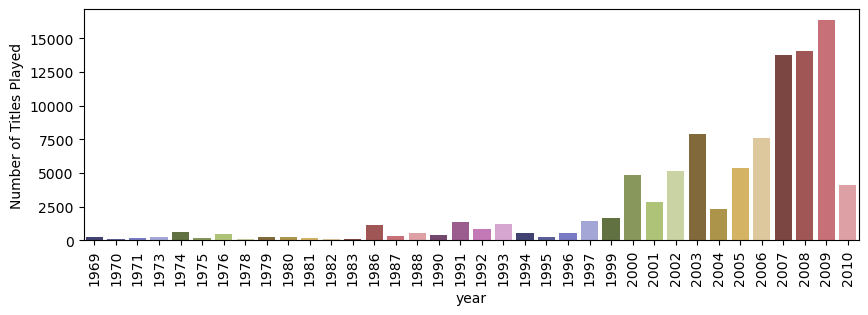

In [26]:
plt.figure(figsize=(10, 3))
sns.barplot(data = count, x='year', y='title', palette='tab20b')
plt.xticks(rotation=90)
plt.ylabel('Number of Titles Played')
plt.show()

- Number of songs from each years plotted, songs from 2009 are most frequent in this dataset. 
- The number of songs increases as year increases indicating the users are listening to newer songs more often. 
- The number of songs in 2010 decreases since 2010 is the last year for our data it might be do to the fact that the we have partial data repoting. 

In [27]:
final_df['artist_name'].value_counts()

artist_name
Coldplay                                   5317
The Killers                                4128
Florence + The Machine                     2896
Kings Of Leon                              2864
the bird and the bee                       2387
                                           ... 
Old 97's                                    107
Jadakiss / Swizz Beatz / OJ Da Juiceman     103
Colossal                                    102
Tavares                                      97
The Prodigy                                  96
Name: count, Length: 232, dtype: int64

In [28]:
artist= pd.DataFrame(final_df.groupby('artist_name').count()['title'])
artist

,title
artist_name,
3 Doors Down,761
A Day To Remember,213
Adam Lambert,540
Aerosmith,403
Alicia Keys,362
...,...
White Denim,108
Yeah Yeah Yeahs,321
Young Bleed,114


- Songs from coldplay appear more than any other artist in the dataset. 
- 3 Doors Down have the most number of songs in the dataset ~3X more than the second artist, A Day to Remeber

## **Recommendation Systems**

### **Popularity Based Recom. Sys.**

- This is ranked based recommendation system, we basically find songs that played more than others and where very popular and recommend them based on this ranking. 
- This is good for Cold start problems, in which a new user is joining the platform and you don't have any historical data to recommend based on them.

In [29]:
mean_count = final_df.groupby('song_id')['play_count'].mean()
play_freq = final_df.groupby('song_id')['play_count'].count()
play_count_df = pd.DataFrame({'avg_count': mean_count, 'user_frequency': play_freq})
play_count_df

,avg_count,user_frequency
song_id,,
21,1.622642,265
22,1.492424,132
52,1.729216,421
62,1.728070,114
93,1.452174,115
...,...,...
9939,1.683983,231
9942,2.486667,150
9960,1.597122,139


In [30]:
def recom_model1(data, n, min_freq): 
    recommend = data[data['user_frequency'] > min_freq].sort_values(by='avg_count', ascending=False)
    return recommend.index[:n]

In [31]:
recom_model1(play_count_df, 10, 100)

Index([7224, 6450, 9942, 5531, 5653, 8483, 2220, 657, 614, 352], dtype='int32', name='song_id')

- Above shows the top 10 songs with frequency of playing by more than 100 users. 

### **Collaborative Filtering Based Recom. Sys.**

`Relevant songs`: song that played higher than the threshold is relevant. If the actual play_count of song is below threshold then it is non-relevant. 
<br>
<br>
`Recommended songs`: song that predicted play_count higher than the threshold is recommended song. If the predicated play_count is below threshold then the song will not be recommended to the user.
<br>
<br>
`False Negative`: It is the frequency relevent songs that are not recommended to the users. This is **opportunity loss** for the service provider. 
<br>
<br>
`False Positive`: It is the frequency of recommended songs that are actually not relevent. This is **recouce loss** for the service provider. 
<br>
<br>
`Recall`: It is the fraction of actually relevant songs that recommended to the user.
<br>
<br>
`Precision`: It is the fraction of recommended songs that are relevent actually. 
<br>
<br>
`Recall@k`: It is the fraction of relevant songs that are recommended to the user in **top k** predications.
<br>
<br>
`Precision@k`: It is the fraction of recommended songs that are relevent in **top k** predications.
<br>
<br>
`F1-socre@k`: It is the harmonic mean of precision@k and recall@k.


#### **Performance Metrics**

In [32]:
def performance_at_k(model, data,  k, threshold): 
    user_est_true = defaultdict(list)
    predictions = model.test(data)
    #Prediction format: Prediction(uid=26071, iid=7103, r_ui=1.0, est=1.625, details={'actual_k': 40, 'was_impossible': False})

    for uid, _,true_r, est, _ in predictions: 
        user_est_true[uid].append((est,true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall) 
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) 

#### **Model 2: User User based Collaborative Filtering**

It doesn't use any song or user info only works with user-item interaction matrix. Let's build such a matrix here: 

In [33]:
reader = Reader(rating_scale=(0,5))
data_matrix = Dataset.load_from_df(final_df[['user_id', 'song_id', 'play_count']], reader)

In [34]:
train_set, test_set = train_test_split(data_matrix, test_size=0.4, random_state=42)

In [78]:
similarity_cat = {'name': 'cosine', 
                    'user_based': True}

user_user_sim = KNNBasic(sim_options = similarity_cat, verbose= True, random_state=1)
user_user_sim.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [79]:
performance_at_k(user_user_sim, test_set, 30, 1.5)

RMSE: 1.0878
Precision:  0.396
Recall:  0.692
F_1 score:  0.504


The F1-score is low, the model is not really performing well expecially on precision with 0.396 score.

In [81]:
final_df[(final_df['user_id'] == 6958) & (final_df['song_id'] == 1671)]

,user_id,song_id,play_count,title,release,artist_name,year
215,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003


- we had above user_id and song_id in our databse which is play_count is 2. Let's see what is the model prediction for this user_id and song_id

In [82]:
user_user_sim.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.80   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8009387435128914, details={'actual_k': 40, 'was_impossible': False})

The predicted play count is 1.80 based on this model insread of 2. 

In [83]:
final_df[(final_df['user_id'] == 6958) & (final_df['song_id'] == 3232)]

,user_id,song_id,play_count,title,release,artist_name,year


- This datapoint doesn't exist in the current data matrix. 

In [84]:
user_user_sim.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.64   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.6386860897998294, details={'actual_k': 40, 'was_impossible': False})

- The model predict 1.64 for this user and item. 

#### **User User based Collaborative Filtering - Hyperparameter Tuning**

Hyperparameters for KNNBasic algorithm are: 
- k --> Maximum number of neighbors to take into account for aggregation. Default k = 40
- min_k --> Minimum number of neighbors to take into account for aggregation. Default min_k = 1
- sim_options: 
    - Similarity measures: 
        `cosine` - Compute the cosine similarity between all pairs of users.

        `msd` - Compute the Mean Squared Difference similarity between all pairs of users.

        `pearson` - Compute the Pearson correlation coefficient between all pairs of users.

        `pearson_baseline` - Compute the (shrunk) Pearson correlation coefficient between all pairs of users using baselines for centering instead of means.
    - min_support --> min number of common items for similarity not to be zero. 

In [52]:
param_grid_uu = {'k': [10, 20, 30], 
                 'min_k': [3, 6, 9], 
                 'sim_options': {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
                                'user_based': [True],
                                'min_support': [2, 4]}
                }

user_user_sim_tune = GridSearchCV(KNNBasic, param_grid_uu, measures=['rmse'], cv=3, n_jobs=-1)
user_user_sim_tune.fit(data_matrix)
print(user_user_sim_tune.best_score['rmse'])
print(user_user_sim_tune.best_params['rmse'])

1.0477577971853465
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [53]:
sim_para = {'name':'pearson_baseline', 'user_based':True, 'min_support': 2}

user_user_sim_optimized = KNNBasic(sim_options =sim_para , k= 30, min_k= 9, random_state=1, verbose=False)
user_user_sim_optimized.fit(train_set)

In [55]:
performance_at_k(user_user_sim_optimized, test_set, 30, 1.5)

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


- As we can see the F1_score improved slightly and the RMSE decrease in this model so overall the hyperparameter tuning improved the performance of the model. 

In [56]:
user_user_sim_optimized.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 24, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.962926073914969, details={'actual_k': 24, 'was_impossible': False})

As we can see the prediction of this specific song_id and user_id improved and the model prediction is closer to the actual play_count. 

In [57]:
user_user_sim_optimized.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.45   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4516261428486725, details={'actual_k': 10, 'was_impossible': False})

##### **Implement the Recom. Sys. for Optimized KNNBasic**

In [60]:
def recom_model2(model, data, user_id, top_n_song,):
    recom = []
    user_item_inter_matrix = data.pivot(index='user_id', columns='song_id', values='play_count')
    non_inter_song = user_item_inter_matrix.loc[user_id][user_item_inter_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_inter_song:
        est_song_score = model.predict(user_id, item_id).est
        recom.append((item_id, est_song_score))
    recom.sort(key=lambda x:x[1], reverse=True)

    return recom[:top_n_song]


In [69]:
proposed_song = recom_model2(user_user_sim_optimized, final_df, 6958, 5)
pd.DataFrame(proposed_song, columns=['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,5531,2.553335
1,317,2.518269
2,4954,2.406776
3,8635,2.396606
4,5943,2.390723


**Correcting the recommendation based on Ranking**

Let's combine the user user collberative filtering with popular song ranking system in the model. 

In [72]:
def ranking_user_songs(proposed_songs, ranking_song):
    songs_rank = ranking_song.loc[[items[0] for items in proposed_songs]].sort_values('user_frequency', ascending=False)[['user_frequency']].reset_index()
    songs_rank = songs_rank.merge(pd.DataFrame(proposed_songs, columns=['song_id', 'predicted_rating']), on='song_id', how='inner')
    songs_rank['corrected_ranking'] = songs_rank['predicted_rating'] - 1 / np.sqrt(songs_rank['user_frequency'])
    return songs_rank.sort_values('corrected_ranking', ascending=False)

In [73]:
ranking_user_songs(proposed_song, play_count_df)

,song_id,user_frequency,predicted_rating,corrected_ranking
0,5531,618,2.553335,2.513109
2,317,411,2.518269,2.468943
1,5943,423,2.390723,2.342101
3,4954,183,2.406776,2.332854
4,8635,155,2.396606,2.316284


#### **Model 3: Item Item based Collaborative Filtering**

In [76]:
similarity_cat = {'name': 'pearson', 
                    'user_based': False}

item_item_sim = KNNBasic(sim_options = similarity_cat, verbose= False, random_state=1)
item_item_sim.fit(train_set)

In [77]:
performance_at_k(item_item_sim, test_set, 30, 1.5)

RMSE: 1.0588
Precision:  0.376
Recall:  0.538
F_1 score:  0.443


- The model performance is worest than the initial user_user based model. Let's do Grid search to see if we can improve the performance. 

In [80]:
final_df[(final_df['user_id'] == 6958) & (final_df['song_id'] == 1671)]
item_item_sim.predict(6958, 1671, r_ui=2, verbose=True )

user: 6958       item: 1671       r_ui = 2.00   est = 1.92   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.91669781984001, details={'actual_k': 10, 'was_impossible': False})

- The perdiction for this song_id and item_id is better than the user user based similarity model. 

In [85]:
item_item_sim.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.00   {'actual_k': 5, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0, details={'actual_k': 5, 'was_impossible': False})

- Prediction for this user nad song id is lower than the user user based model. 

#### **Item Item based Collaborative Filtering - Hyperparameter Tuning**

In [86]:
param_grid_ii = {'k': [10, 20, 30], 
                 'min_k': [3, 6, 9], 
                 'sim_options': {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
                                'user_based': [False],
                                'min_support': [2, 4]}
                }

item_item_sim_tune = GridSearchCV(KNNBasic, param_grid_ii, measures=['rmse'], cv=3, n_jobs=-1)
item_item_sim_tune.fit(data_matrix)
print(item_item_sim_tune.best_score['rmse'])
print(item_item_sim_tune.best_params['rmse'])

1.0219952252659874
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


In [91]:
sim_para = {'name':'pearson_baseline', 'user_based':False, 'min_support': 2}

item_item_sim_optimized = KNNBasic(sim_options =sim_para , k= 30, min_k= 6, random_state=1, verbose=False)
item_item_sim_optimized.fit(train_set)

In [92]:
performance_at_k(item_item_sim_optimized, test_set, 30, 1.5)

RMSE: 1.0328
Precision:  0.408
Recall:  0.665
F_1 score:  0.506


In [95]:
item_item_sim_optimized.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9634957386781853, details={'actual_k': 10, 'was_impossible': False})

- The estimation is very closed for this model. 1.96 vs 2. 

In [96]:
item_item_sim_optimized.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.28   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2759946618244609, details={'actual_k': 10, 'was_impossible': False})

- The prediction for this item that we don't have information about is 1.27

##### **Implement the Recom. Sys. for Optimized KNNBasic**

In [99]:
proposed_song_item_item = recom_model2(item_item_sim_optimized, final_df, 6958, 5)
pd.DataFrame(proposed_song_item_item, columns=['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,2342,2.653903
1,5101,2.386577
2,139,2.313727
3,7519,2.270864
4,8099,2.212702


**Correcting the recommendation based on Ranking**

In [100]:
ranking_user_songs(proposed_song_item_item, play_count_df)

,song_id,user_frequency,predicted_rating,corrected_ranking
4,2342,111,2.653903,2.558987
2,5101,130,2.386577,2.298871
3,139,119,2.313727,2.222057
1,7519,168,2.270864,2.193712
0,8099,275,2.212702,2.152399


### **Model Based Collaborative Filtering Recom. Sys. Matrix Factoriation**

#### **Model 4: Signular Value Decomposition (SVD)**

In [101]:
svd_model = SVD(random_state=1)
svd_model.fit(train_set)

In [102]:
performance_at_k(svd_model, test_set, 30, 1.5)

RMSE: 1.0252
Precision:  0.41
Recall:  0.633
F_1 score:  0.498


- The F1-score is 0.498 for this model.

In [103]:
svd_model.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.27   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.267473397214638, details={'was_impossible': False})

- The estimation for number of times the song play for this user is 1.27 compare to the actual value that is 2. This is a very low number. Let's perform hyperparameter tuning to find better model. 

In [104]:
svd_model.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.56   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5561675084403663, details={'was_impossible': False})

- The estimation is 1.55 for a song that we don't have information on. 

#### **Matrix Factorization - Hyperparameter Tuning**

There are lot's of parameter to tune for SVD model. Out of all of them we will tune only `n_epochs`, `Ir_all`, `reg_all`.

In [106]:
param_grid_svd= {'n_epochs': [10, 20, 30], 
                 'lr_all': [0.001, 0.005, 0.01], 
                 'reg_all': [0.2, 0.4, 0.6]}

svd_tune = GridSearchCV(SVD, param_grid_svd, measures= ['rmse'], n_jobs=-1, cv=3)
svd_tune.fit(data_matrix)
print(svd_tune.best_score['rmse'])
print(svd_tune.best_params['rmse'])

1.0122579813650385
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [107]:
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)
svd_optimized.fit(train_set)

In [108]:
performance_at_k(svd_optimized, test_set, 30, 1.5)

RMSE: 1.0141
Precision:  0.415
Recall:  0.635
F_1 score:  0.502


- F1-score improved on the tuned model and the model slightly performing better. 

In [109]:
svd_optimized.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.34   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.3432395286125096, details={'was_impossible': False})

- The model predict 1.34 play count for a song and user that have actual value of 2. 

In [110]:
svd_optimized.predict(6958, 3232,  verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.44   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.442548446117648, details={'was_impossible': False})

- The model perdict 1.44 for song and user that we don't have any score for it. 

##### **Recom. Sys. for Optimized SVD**

In [111]:
proposed_song_svd = recom_model2(svd_optimized, final_df, 6958, 5)
pd.DataFrame(proposed_song_svd, columns=['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,7224,2.601899
1,5653,2.108728
2,8324,2.014091
3,6450,1.952493
4,9942,1.940115


**Correcting the recommendation based on Ranking**

In [112]:
ranking_user_songs(proposed_song_svd, play_count_df)

,song_id,user_frequency,predicted_rating,corrected_ranking
2,7224,107,2.601899,2.505225
1,5653,108,2.108728,2.012502
4,8324,96,2.014091,1.912029
0,9942,150,1.940115,1.858465
3,6450,102,1.952493,1.853478


### **Clustering Based Recom. Sys.**

#### **Model 5: Coclustering**

In [113]:
coclustering_model = CoClustering(random_state=1)
coclustering_model.fit(train_set)

In [114]:
performance_at_k(coclustering_model, test_set, 30, 1.5)

RMSE: 1.0487
Precision:  0.397
Recall:  0.582
F_1 score:  0.472


In [115]:
coclustering_model.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.29   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.2941824757363074, details={'was_impossible': False})

- The model predict 1.29 value for user and song id that had actual value of 2 for play_count. 

In [116]:
coclustering_model.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.48   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4785259100797417, details={'was_impossible': False})

Predict 1.48 for song and user that we didn't have any value for it. 

#### **Clustering - Hyperparameter Tuning**

- The parameters that we need to tune are: 

`n_cltr_u` – Number of user clusters. Default is 3.

`n_cltr_i` – Number of item clusters. Default is 3.

`n_epochs` – Number of iteration of the optimization loop. Default is 20.

In [120]:
param_grid_cocluster= {'n_epochs': [10, 20, 30, 40, 50, 60], 
                 'n_cltr_i': [2, 3, 4, 5, 6, 7 ,8], 
                 'n_cltr_u': [2, 3, 4, 5, 6, 7, 8]}

coclustering_tune = GridSearchCV(CoClustering, param_grid_cocluster, measures= ['rmse'], n_jobs=-1, cv=3)
coclustering_tune.fit(data_matrix)
print(coclustering_tune.best_score['rmse'])
print(coclustering_tune.best_params['rmse'])

1.034644979888338
{'n_epochs': 30, 'n_cltr_i': 7, 'n_cltr_u': 2}


In [121]:
coclustering_optimized = CoClustering(n_epochs=30, n_cltr_i=7, n_cltr_u=2, random_state=1)
coclustering_optimized.fit(train_set)

In [122]:
performance_at_k(coclustering_optimized, test_set, 30, 1.5)

RMSE: 1.0404
Precision:  0.39
Recall:  0.569
F_1 score:  0.463


In [123]:
coclustering_optimized.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.16   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.1576053940275937, details={'was_impossible': False})

In [124]:
coclustering_optimized.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.26   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2618247865205379, details={'was_impossible': False})

##### **Recom. Sys. for Clustering**

In [125]:
proposed_song_clustering = recom_model2(coclustering_optimized, final_df, 6958, 5)
pd.DataFrame(proposed_song_clustering, columns=['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,7224,2.509227
1,8324,2.295423
2,5653,2.271102
3,6860,2.058262
4,657,1.973572


**Correcting the recommendation based on Ranking**

In [126]:
ranking_user_songs(proposed_song_clustering, play_count_df)

,song_id,user_frequency,predicted_rating,corrected_ranking
3,7224,107,2.509227,2.412554
4,8324,96,2.295423,2.193361
2,5653,108,2.271102,2.174877
0,6860,169,2.058262,1.981338
1,657,151,1.973572,1.892194


## **Conclusion**

In this case study we built recommendation system for the following 5 models and did hyperparameter tuning: 

- Ranked-based using average
- User-User-similarity-based collaborative filtering
- Item-Item-similarity-based collaborative filtering
- Matrix-Factorization Collaorative filtering
- Clustering-based

Based on the performance of these models we will use optimized user-user based collaborative filtering for future predication which has the highest F1-Socre of 0.525. 

To further imrpove this model we should use other models that includes item and users features as well. 